<!-- Simon-Style -->
<p style="font-size:19px; text-align:left; margin-top:    15px;"><i>German Association of Actuaries (DAV) — Working Group "Explainable Artificial Intelligence"</i></p>
<p style="font-size:25px; text-align:left; margin-bottom: 15px"><b>Use Case SOA GLTD Experience Study:<br>
GBT - Drop1 decrease in predictive performance
</b></p>
<p style="font-size:19px; text-align:left; margin-bottom: 15px; margin-bottom: 15px">Guido Grützner (<a href="mailto:guido.gruetzner@quantakt.com">guido.gruetzner@quantakt.com</a>)

# Introduction

This notebook defines and calculates the explainability statistics "drop1 decrease in predictive performance" for the GBT. 

Drop1 is a simple and straightforward approach to variable importance. The importance of a variable is defined as the decrease in predictive power if this variable is dropped from the set of available inputs. Since predictive power is measured, as always, by the loss on a test set, this directly translates into the increase in loss. 

The method is implemented in the code below as follows:
1. Fix a train and test set.
2. Fit the base model on the train set and record its loss on the test set.
3. Loop through all available input variables:
    1. Call the current input variable `curval`
    2. Fit the model on the train set using all inputs except `curval`. Record the loss on the test set of this model.
4. Calculate the difference (i.e. increase) in loss between the base model and each model with an input dropped.
5. Output the list of variables sorted by the difference.

The most important, i.e. the best ranked, variable will be that variable which has the worst, i.e. largest, loss. The full model, called below "none" because no variable has been dropped, should in theory always have the lowest loss, i.e. it should be ranked at the bottom. Of course, in practice this may fail due to the difference between train and test evaluation and sampling error.

# Initialisation

In [2]:
from sklearn.ensemble import HistGradientBoostingClassifier
from scipy.stats import rankdata

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt

# adjust according to your age and vision
plt.rcParams['axes.titlesize'] = 20   # Title font size
plt.rcParams['axes.labelsize'] = 15   # Axis label font size
plt.rcParams['xtick.labelsize'] = 12  # X-axis tick label font size
plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick label font size 


import gltd_utilities

import time
import pickle
import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True

# adjust accordingly, more CPUs is faster but then script may block PC
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

* Adapt the path for the data file in the call of `load_gltd_data`, if necessary.
* Adapt pct to your requirements for anything between  $0.05\leq pct\leq1$. 
* Input 1 uses all data available, lower numbers the respective fraction. Below 0.05 predictions become somehwat volatile.

In [3]:
tic = time.time()
path_to_data = "./"
(X, Y, ID, nm_cat, nm_num, seed, rng) = gltd_utilities.load_gltd_data(
                                            path_to_data, pct=0.3)
seed

'83900595774784117429716969499405152150'

In [4]:
# file for cached bootstrap
cachefile = path_to_data + "cache_drop1_boost.pkl"

In [5]:
# Check for cache
if os.path.exists(cachefile):
    with open(cachefile, 'rb') as f:
        cachedata = pickle.load(f)
    
    typelist = cachedata["typelist"]
    lltrainlist = cachedata["lltrainlist"]
    lltestlist = cachedata["lltestlist"]
    nsplit = cachedata["nsplit"]
    allvars = cachedata["allvars"]

else:
    # Input variables to use
    allvars = nm_cat + nm_num

    gss = GroupShuffleSplit(n_splits=30, train_size=0.7,
                                random_state=rng.integers(low=0, high=1000))
    nsplit = gss.get_n_splits()

    # container for results
    typelist = list()
    lltrainlist = list()
    lltestlist = list()

    for ii, (trainidx, testidx) in enumerate(gss.split(X, groups=ID)):
        # print("--------------------------------------------")
        print(f"Run {ii + 1}:")
        # print("--------------------------------------------")

        xtrain, xtest = X.iloc[trainidx, :], X.iloc[testidx, :]
        ytrain, ytest = Y.iloc[trainidx], Y.iloc[testidx]

        # Fit all-in model
        md = HistGradientBoostingClassifier(
            interaction_cst = None,
            categorical_features=list(nm_cat),
            max_iter=1000,
            learning_rate=0.025,
            max_leaf_nodes=100,
            random_state=rng.integers(low=0, high=1000))

        md.fit(xtrain, ytrain)

        # performance statistics
        phat = {"train": md.predict_proba(xtrain), 
                "test": md.predict_proba(xtest)}
        typelist = typelist + ["none"]
        lltrainlist = (lltrainlist 
                    + [log_loss(ytrain, phat["train"])])
        lltestlist = (lltestlist 
                    + [log_loss(ytest, phat["test"])])
        
        # Loop over all drop1 models
        for dropvar in allvars:
            # print(dropvar)
            
            curvars = set(allvars) - {dropvar}

            # fit the drop model
            md = HistGradientBoostingClassifier(
                interaction_cst = None,
                categorical_features=list(set(nm_cat).intersection(curvars)),
                max_iter=1000,
                learning_rate=0.025,
                max_leaf_nodes=100,
                random_state=rng.integers(low=0, high=1000))

            md.fit(xtrain.drop(dropvar, axis=1), ytrain)

            # performance statistics
            phat = {"train": md.predict_proba(xtrain), 
                    "test": md.predict_proba(xtest)}
            typelist = typelist + [dropvar]
            lltrainlist = (lltrainlist 
                    + [log_loss(ytrain, phat["train"])])
            lltestlist = (lltestlist 
                    + [log_loss(ytest, phat["test"])])
            
    # write results of bootstrap to disk
    cachedata = {"typelist": typelist, "lltrainlist": lltrainlist,
                "lltestlist": lltestlist, 
                "nsplit": nsplit,
                "allvars": allvars}

    with open(cachefile, 'wb') as f:
            pickle.dump(cachedata, f)

## Analysis

In [6]:
# remember: row-major!
lltrainarr = 100**2 * np.array(lltrainlist).reshape(nsplit, 1 + len(allvars))
lltestarr = 100**2 * np.array(lltestlist).reshape(nsplit, 1 + len(allvars))
decpp_train = lltrainarr - lltrainarr[:,0].reshape(-1,1)
decpp_test = lltestarr - lltestarr[:,0].reshape(-1,1)

resdf = pd.DataFrame({
    "decpp train": np.round(np.mean(decpp_train, axis=0),1),
    "decpp test": np.round(np.mean(decpp_test, axis=0),1)},
    index=typelist[:(1 + len(allvars))]
)

resdf.index.name = "dropped"
resdf.sort_values(["decpp test"], ascending=False)

,decpp train,decpp test
dropped,,
Original_Social_Security_Award_Status,30.1,27.4
Duration_Month,5.5,12.9
OwnOccToAnyTransition,6.1,6.9
Diagnosis_Category,10.7,6.8
Taxability_of_Benefits,4.3,4.6
Updated_Social_Security_Award_Status,2.0,2.0
Integration_with_STD,2.3,0.8
Elimination_Period,3.0,0.5
Benefit_Max_Limit_Proxy,2.2,0.1


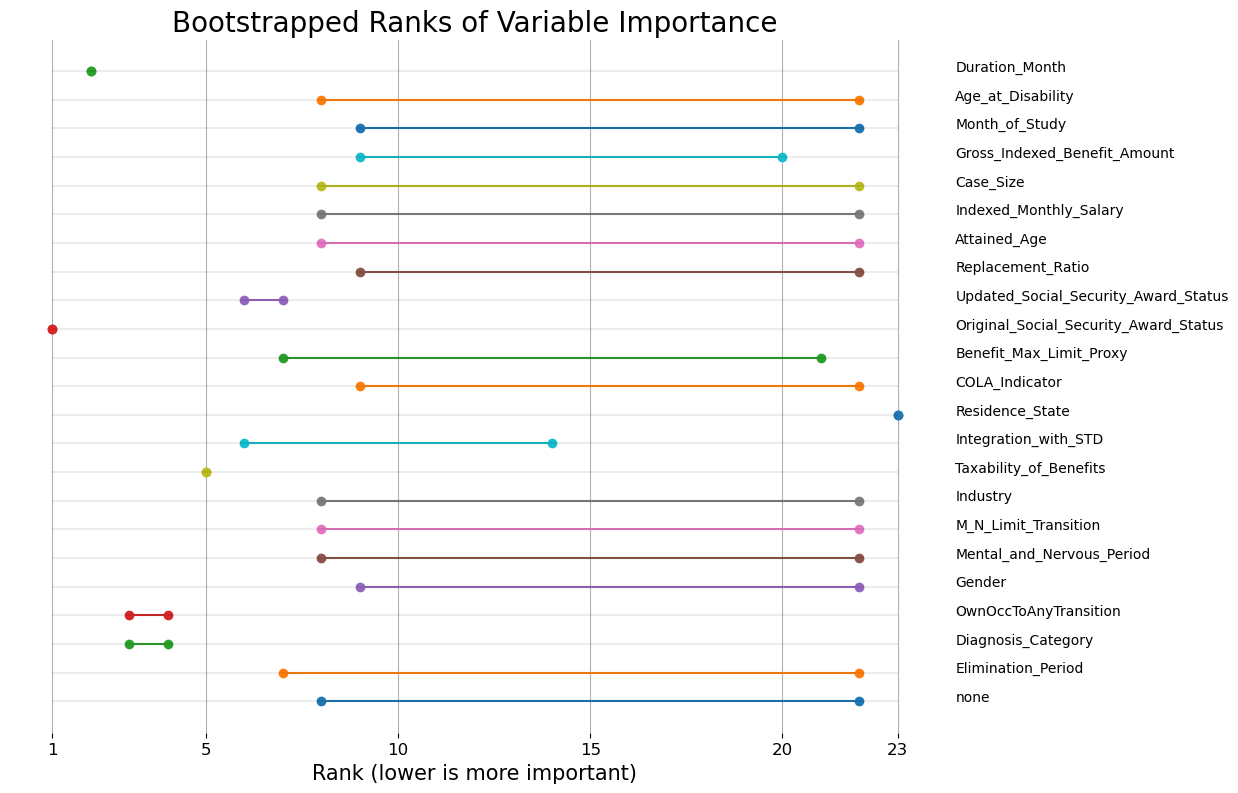

In [7]:
vi = 2 + len(allvars) - np.apply_along_axis(rankdata, 1, lltestarr)
hilist = np.max(vi, axis=0)
lolist = np.min(vi, axis=0)
lims = [(lo, hi) for lo, hi in zip(lolist, hilist)]
fig, ax = plt.subplots(figsize = (12,9))
tmp = len(lims) - 1
for i, (start, end) in enumerate(lims):
    ax.plot([start, end],  [i, i], marker='o')
    ax.plot([1, tmp+1],  [i, i], color="black", lw=0.1)
    ax.text(tmp + 2.5, i, typelist[i])
ax.set_yticks([])
ax.set_xticks([1,5,10,15,20,len(allvars) + 1])
ax.grid(which="major", axis="x")
ax.set_xlabel("Rank (lower is more important)")
# Remove bounding box (spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
dummy = ax.set_title("Bootstrapped Ranks of Variable Importance")

# Interpretation

 The analysis above provides evidence for the split of importance into two groups:
* The top inputs, which are clearly important. They are not only consistently ranked in the top, but their relative position within this group is (almost) fixed. They are
  1. Original_Social_Security_Award_Status
  2. Duration_Month
  3. OwnOccToAnyTransition
  4. Diagnosis_Category
  5. Taxability_of_Benefits
  6.  Updated_Social_Security_Award_Status
* For all other inputs importance fluctuates wildly over a wide range. Ranks in this group seem to be mainly noise. For example, the entry "none" is the full model. Without sampling error, this entry should always be ranked 1 or last, as this is the run with all variables present or no variable dropped. This divergence is remarkable, given the very large sample size (test data is roughly 600K observations).

Note further that, due to run-time considerations, the size of the bootstrap samples is rather small (N=30) and that the uncertainty of ranking can only grow with larger bootstrap samples. So this estimate of the reliability of this variable importance statistic may be overly optimistic.

In [8]:
print(f"Time it took: {np.ceil((time.time() - tic)/60)}min.")

Time it took: 1.0min.
